In [2]:
# | echo: false
import os
import subprocess
from os import fspath
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from osgeo import gdal


%load_ext autoreload
%autoreload 2

%matplotlib inline

# Dolphin basic walkthrough

This notebook demonstrates the basic usage of the `dolphin` command line tool to execute the stack-based phase linking workflow.
In this notebook, we will

- Prepare a configuration file for a stack of coregistered single-look complex (SLC) radar images with `dolphin config`
- Run this configuration file with `dolphin run` 
- Inspect the resulting output interferograms
- Show the most common parameters you may want to change or customize



## Setup

We first need to install `dolphin` as outlined in the [Getting Started](https://dolphin-insar.readthedocs.io/en/getting-started) section of the documentation. 
We can check that we have the command line tool correctly installed by running

In [3]:
# | echo: true
!dolphin --help

usage: dolphin [-h] [--version] {run,config,unwrap} ...

options:
  -h, --help           show this help message and exit
  --version            show program's version number and exit

subcommands:
  {run,config,unwrap}


or by importing dolphin in python

In [4]:
# | echo: true
import dolphin

print(dolphin.__version__)

0.4.1.post1.dev3+g5ab5346.d20230927


If you have a GPU available to you, you can follow the extra installation set up so that the GPU verion of the workflow run.
This can be 5-20x faster than the CPU version, depending on the sie of your workstation.

## Input dataset

We will use a stack of Sentinel-1 SLCs from descending track 87. 
These were produced by [COMPASS](https://github.com/opera-adt/COMPASS) and are available for download on Zenodo (TODO).

A brief walkthrough of how to produce these is included in the Appendix

In [5]:
os.chdir("/home/staniewi/dev/beta-delivery/delivery_data_small")

In the `input_slcs` directory, we have stored the NetCDF-format SLCs:

In [7]:
!ls input_slcs

t042_088905_iw1_20221107.h5  t042_088906_iw1_20221107.h5
t042_088905_iw1_20221119.h5  t042_088906_iw1_20221119.h5
t042_088905_iw1_20221201.h5  t042_088906_iw1_20221201.h5
t042_088905_iw1_20221213.h5  t042_088906_iw1_20221213.h5


The naming convention comes from COMPASS, where, for example, `t042_088905_iw1_20221119.h5` means
- `t042` is Sentinel-1 track (relative orbit) 42
- 088905 the Burst IDs from [ESA's Burst database](https://sentinel.esa.int/web/sentinel/-/publication-of-brust-id-maps-for-copernicus-sentinel-1/1.1).
- `iw1` indicates these are from the first subswath (since the "Burst ID" is repeated for subswaths IW1,2,3.)
- `20221119` is the acquisition date formatted as `%Y%m%d`

Note that we specified the data we want is in `/data/VV`. This is not necessary for other SLC formats (e.g. binary files from ISCE2).

You can process one single stack, or multiple geocoded stacks. If you have different spatial regions, `dolphin` will form burst-wise interferograms and stitch them before unwrapping.

Let's make a configuration file for all of the bursts:

In [12]:
!dolphin config --slc-files input_slcs/t*.h5 --subdataset "/data/VV"

Saving configuration to dolphin_config.yaml


If you need more fine-grained control of which SLCs to include, you can list the file locations in a text file separated by new lines and refer to it with an `@` symbol. For example: 

In [13]:
# Store the files we want in a text file called slc_list.txt
# Here we're just using `ls` to all the 185683 SLCs
!ls input_slcs/t*h5 > slc_list.txt

# We use the same `--slc-files` argument, but now use an @ to say look inside the file
!dolphin config --slc-files @slc_list.txt -o new_config.yaml --subdataset "/data/VV"

Saving configuration to new_config.yaml


This is an equivalent way to point to the SLCs you want to process. The configs should be the same (except for the creation time, which is logged):

In [14]:
!diff new_config.yaml dolphin_config.yaml

162c162
< creation_time_utc: '2023-10-03T17:14:25.047623'
---
> creation_time_utc: '2023-10-03T17:14:17.143600'


This command created a YAML file in our current directory. Most of the contents were filled in by the workflow defaults:

In [16]:
!head -20 dolphin_config.yaml

input_options:
  # If passing HDF5/NetCDF files, subdataset to use from CSLC files. .
  #   Type: string | null.
  subdataset: /data/VV
  # Format of dates contained in CSLC filenames.
  #   Type: string.
  cslc_date_fmt: '%Y%m%d'
# REQUIRED: list of CSLC files, or newline-delimited file containing list of CSLC files.
#   Type: array.
cslc_file_list:
  - input_slcs/t042_088905_iw1_20221107.h5
  - input_slcs/t042_088906_iw1_20221107.h5
  - input_slcs/t042_088905_iw1_20221119.h5
  - input_slcs/t042_088906_iw1_20221119.h5
  - input_slcs/t042_088905_iw1_20221201.h5
  - input_slcs/t042_088906_iw1_20221201.h5
  - input_slcs/t042_088905_iw1_20221213.h5
  - input_slcs/t042_088906_iw1_20221213.h5
# Byte mask file used to ignore low correlation/bad data (e.g water mask). Convention is 0
#   for no data/invalid, and 1 for good data. Dtype must be uint8.


You can browse the YAML file for all the configuration options.

### Common configuration

#### Strides
You can create a downsampled version of the output using `--strides`. 
This will save time/space by creation an output with coarser pixel spacing than your SLCs.
For COMPASS outputs, adding `--strides 6 3` will convert the inputs at (5m, 10m) in `(x, y)` (aka `(easting, northing)`) to a (30 meter, 30 meter) output.


#### Specify the working directory

Use `--working-directory` to save all rasters to a different directory other than the one you call `dolphin run` from.

#### Specify how many CPUs to use

Use `--threads-per-worker` to specify the number of CPUs you would like the workflow to use.

####  (For geocoded SLCs) process different burst stacks in parallel

By adding the `--n-parallel-bursts`, you can process separate geocoded bursts at the same time (assuming sufficient resources are available).

#### Multiscale unwrapping

If you have [tophu](https://github.com/isce-framework/tophu) installed, you can also run multiscale unwrapping on the interferograms.
This is configurable by specifying 
1. How many tiles you want to split each interferogram into with `--ntiles`
2. How much extra multilooking you'd like to do for the coarse unwrapping with `--downsample-factor`

### Full configuration command

In [21]:
cmd = (
    'dolphin config --slc-files @slc_list.txt  --subdataset "/data/VV"  --strides 6 3 '
    "--n-parallel-bursts 2 --threads-per-worker 16 "
    " --ntiles 2 2 --downsample-factor 3 3"
)
subprocess.run(cmd, shell=True)

Saving configuration to dolphin_config.yaml


CompletedProcess(args='dolphin config --slc-files @slc_list.txt  --subdataset "/data/VV"  --strides 6 3 --n-parallel-bursts 2 --threads-per-worker 16  --ntiles 2 2 --downsample-factor 3 3', returncode=0)

## Running the workflow

Now that we have created the `dolphin_config.yaml` file, we can run it using `dolphin run`

In [22]:
%%time
!dolphin run dolphin_config.yaml

[2023-10-03 10:33:47] INFO     Found SLC files from 2 bursts       ]8;id=381548;file:///u/aurora-r0/staniewi/repos/dolphin/src/dolphin/workflows/s1_disp.py\s1_disp.py]8;;\:]8;id=436871;file:///u/aurora-r0/staniewi/repos/dolphin/src/dolphin/workflows/s1_disp.py#68\68]8;;\
                      INFO     Running wrapped phase         ]8;id=597451;file:///u/aurora-r0/staniewi/repos/dolphin/src/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=995919;file:///u/aurora-r0/staniewi/repos/dolphin/src/dolphin/workflows/wrapped_phase.py#39\39]8;;\
                               estimation in                                    
                               /u/aurora-r0/staniewi/dev/bet                    
                               a-delivery/delivery_data_smal                    
                               l/t042_088906_iw1                                
                      INFO     Running wrapped phase         ]8;id=227730;file:///u/aurora-r0/staniewi/

### Outputs

For each stack of SLCs (which may be > 1 when processing COMPASS GSLCs), the workflow creates a folder for
1. persistent scatter outputs (`PS`)
2. linked phase optimized SLCs (`linked_phase`)
3. (virtual) interferograms formed using the optimized SLCs (`interferograms`)

Here we have two of these subdirectories named `t042_088905_iw1` and `t042_088906_iw1`.
Additionally, you may notice
- The `slc_stack.vrt` is a VRT file pointing to the input SLCs for that burst stack.
- The `nodata_mask.tif` has been created from the COMPASS GSLC metadata to skip over the nan regions

Last, there is a top-level directory for `interferograms` that have been stitched together, and an `unwrapped` folder for the outputs of phase unwrapping.

```
$ tree -L 2
.
├── dolphin_config.yaml
├── input_slcs
│   ├── t042_088905_iw1_20221107.h5
│   ├── t042_088905_iw1_20221119.h5
│   ├── t042_088905_iw1_20221201.h5
│   ├── t042_088905_iw1_20221213.h5
│   ├── t042_088906_iw1_20221107.h5
│   ├── t042_088906_iw1_20221119.h5
│   ├── t042_088906_iw1_20221201.h5
│   └── t042_088906_iw1_20221213.h5
├── interferograms
│   └── stitched
├── new_config.yaml
├── slc_list.txt
├── t042_088905_iw1
│   ├── interferograms
│   ├── linked_phase
│   ├── nodata_mask.tif
│   ├── PS
│   ├── slc_stack.vrt
│   └── unwrapped
├── t042_088906_iw1
│   ├── interferograms
│   ├── linked_phase
│   ├── nodata_mask.tif
│   ├── PS
│   ├── slc_stack.vrt
│   └── unwrapped
└── unwrapped
    ├── 20221107_20221119.unw.conncomp
    └── 20221107_20221119.unw.tif
    └── ...

```

## Visualization using `sweets`

The outputs can be plotted using any tool capable of reading GDAL-compatible rasters. 
Here, we'll use some [basic plotting tools included in `sweets`](https://github.com/isce-framework/sweets/blob/d9ea016adb521534a7696c3082f1810a9e51d373/src/sweets/plotting.py) for browsing through images interactively:

In [49]:
file_list = sorted(Path("interferograms/stitched/").glob("*.int"))
print(f"Found {len(file_list)} interferograms")

cor_list = sorted(Path("interferograms/stitched/").glob("*.cor"))
print(f"Found {len(file_list)} correlation files")

unw_list = sorted(Path("unwrapped/").glob("*.unw.tif"))
print(f"Found {len(file_list)} unwrapped interferograms")

conncomp_list = sorted(Path("unwrapped/").glob("*.unw.conncomp"))

Found 3 interferograms
Found 3 correlation files
Found 3 unwrapped interferograms


Browsing 3 ifgs.
Found 3 .unw.tif files
Found 3 .unw.conncomp files


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

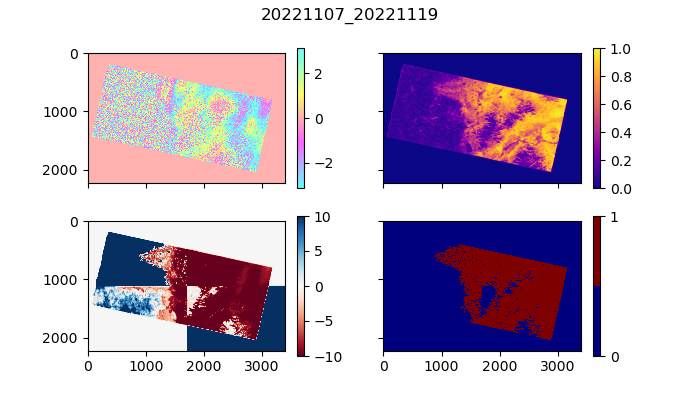

In [52]:
# requires matplotlib and jupyter-widgets to be installed: https://ipywidgets.readthedocs.io/en/latest/
%matplotlib widget
import sweets.plotting


sweets.plotting.browse_ifgs(
    file_list=file_list,
    cor_list=cor_list,
    unw_list=unw_list,
    conncomp_list=conncomp_list,
    vm_cor=1,
)

In [ ]:
sweets.plotting.browse_ifgs(file_list=file_list, vm_cor=50_000)

## Preparing outputs for MintPy

The [`prep_mintpy.py` script](https://github.com/isce-framework/sweets/blob/d9ea016adb521534a7696c3082f1810a9e51d373/scripts/prep_mintpy.py) has been added to `sweets` in order to prepare the geocoded unwrapped outputs for further time series analysis in MintPy:

Note: This requires that `"input_slcs/"` has the `static_layers_` files in addition to the SLCs. 
MintPy needs them to create the `geometry/` HDF5 stack.



In [37]:
cmd = """~/repos/sweets/scripts/prep_mintpy.py -m input_slcs/ -c "interferograms/stitched/*cor" -u "unwrapped/*unw.tif" --single"""
# subprocess.run(cmd, shell=True)